<a href="https://colab.research.google.com/github/lucasyeh01/2025_9_18_Homework/blob/main/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 146MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 34.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 82.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.86MB/s]


Epoch 1, Average loss: 164.1801
====> Test set loss: 127.0674
Epoch 2, Average loss: 121.6859
====> Test set loss: 115.7865
Epoch 3, Average loss: 114.5399
====> Test set loss: 111.8455
Epoch 4, Average loss: 111.5511
====> Test set loss: 109.8525
Epoch 5, Average loss: 109.7760
====> Test set loss: 108.5734
Epoch 6, Average loss: 108.6037
====> Test set loss: 107.3782
Epoch 7, Average loss: 107.7388
====> Test set loss: 106.8343
Epoch 8, Average loss: 107.0746
====> Test set loss: 106.3067
Epoch 9, Average loss: 106.5584
====> Test set loss: 105.9787
Epoch 10, Average loss: 106.0749
====> Test set loss: 105.5025
Epoch 11, Average loss: 105.7740
====> Test set loss: 105.2814
Epoch 12, Average loss: 105.4282
====> Test set loss: 105.0797
Epoch 13, Average loss: 105.1747
====> Test set loss: 104.6200
Epoch 14, Average loss: 104.8949
====> Test set loss: 104.4580
Epoch 15, Average loss: 104.6790
====> Test set loss: 104.4728
Epoch 16, Average loss: 104.4587
====> Test set loss: 104.2188
E

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figu

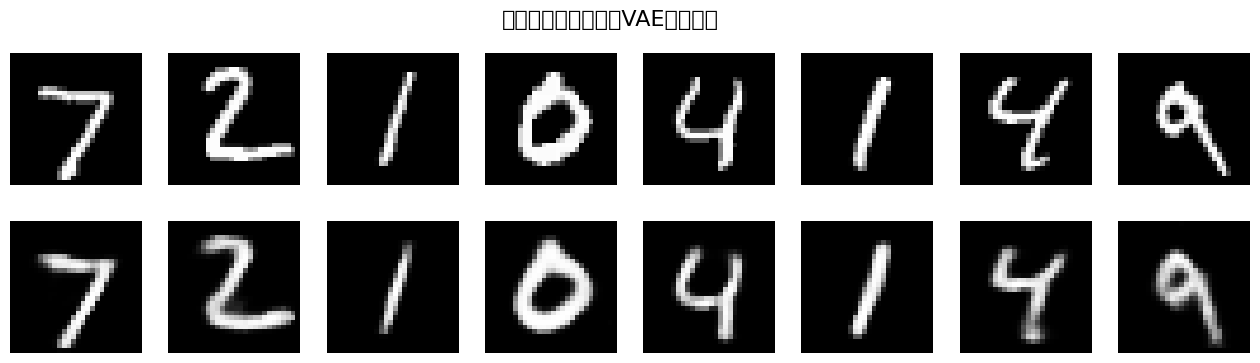

In [1]:
# -*- coding: utf-8 -*-
# 使用 VAE 重建 MNIST 手寫數字

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ======================
# 參數設定
# ======================
batch_size = 128
epochs = 20
lr = 1e-3
latent_dim = 20  # 潛在空間維度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================
# 資料載入
# ======================
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ======================
# VAE 模型
# ======================
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# ======================
# Loss function
# ======================
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# ======================
# 訓練 & 測試
# ======================
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch}, Average loss: {train_loss/len(train_loader.dataset):.4f}")

def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print(f"====> Test set loss: {test_loss:.4f}")

for epoch in range(1, epochs + 1):
    train(epoch)
    test()

# ======================
# 結果顯示
# ======================
with torch.no_grad():
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.to(device)
    recon_batch, _, _ = model(test_batch)

    n = 8  # 顯示前 8 張
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # 原始圖像
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_batch[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")

        # 重建圖像
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_batch[i].cpu().view(28, 28), cmap="gray")
        plt.axis("off")

    plt.suptitle("上：原始圖片，下：VAE重建結果", fontsize=16)
    plt.show()
